In [1]:
# Imports for Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score,
    brier_score_loss, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import calibration_curve
import scipy.stats as stats
from itertools import combinations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


In [2]:
# Filter Warnings

warnings.filterwarnings('ignore')

In [3]:
# Plotting Style

plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# Loading Data for Evaluation

# Loads the saved results and models
results_df = pd.read_csv('../results/baseline_model_comparison.csv')
feature_importance = pd.read_csv('../results/feature_importance_xgboost.csv')

# Loads trained models
lr_best = joblib.load('../results/models/logistic_regression_best.pkl')
svm_best = joblib.load('../results/models/svm_rbf_best.pkl')
xgb_best = joblib.load('../results/models/xgboost_best.pkl')

# Loads test data
X_test = pd.read_csv('../data/processed/X_test_stratified.csv')
y_test = pd.read_csv('../data/processed/y_test_stratified.csv').iloc[:, 0]
X_test_scaled = pd.read_csv('../data/processed/X_test_scaled.csv')

# Academic benchmarks
TARGET_PRECISION = 0.57
TARGET_RECALL = 0.34
TARGET_F1 = 0.43

## 1. Summary and Results Overview

In [8]:
# Summary and Results Overview

print("Summary and Results Overview")

# Generates predictions for ALL models
lr_pred = lr_best.predict(X_test)
lr_pred_proba = lr_best.predict_proba(X_test)[:, 1]

svm_pred = svm_best.predict(X_test_scaled)
svm_pred_proba = svm_best.predict_proba(X_test_scaled)[:, 1]

xgb_pred = xgb_best.predict(X_test)
xgb_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Model Performance Summary
print("\nModel Performance Summary")
performance_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM (RBF)', 'XGBoost', 'Academic Target'],
    'Precision': [precision_score(y_test, lr_pred), 
                 precision_score(y_test, svm_pred),
                 precision_score(y_test, xgb_pred), 
                 TARGET_PRECISION],
    'Recall': [recall_score(y_test, lr_pred),
              recall_score(y_test, svm_pred),
              recall_score(y_test, xgb_pred),
              TARGET_RECALL],
    'F1-Score': [f1_score(y_test, lr_pred),
                f1_score(y_test, svm_pred),
                f1_score(y_test, xgb_pred),
                TARGET_F1],
    'AUC-ROC': [roc_auc_score(y_test, lr_pred_proba),
               roc_auc_score(y_test, svm_pred_proba),
               roc_auc_score(y_test, xgb_pred_proba),
               np.nan]
})

print(performance_summary.round(3).to_string(index=False))

# Key Findings and Business Implications
print("\n" + "Key Findings and Business Implications:")
print("- Best Model: XGBoost (F1: 29.1%, Precision: 23.4%, Recall: 38.8%)")
print("- Academic Gap: 67.7% of target F1-score achieved")
print("- High Recall Models: LR/SVM identify 70%+ of successful startups")
print("- Precision Challenge: All models struggle with false positive control")
print("- Business Value: Models provide meaningful screening capability")

# Academic Benchmark Achievement Status
print("\n" + "Academic Benchmark Achievment:")
best_model = performance_summary.iloc[2]  # XGBoost
print(f"- Precision: {best_model['Precision']:.1%} vs {TARGET_PRECISION:.1%} target (Gap: {(TARGET_PRECISION - best_model['Precision']):.1%})")
print(f"- Recall: {best_model['Recall']:.1%} vs {TARGET_RECALL:.1%} target (Exceeded by: {(best_model['Recall'] - TARGET_RECALL):.1%})")
print(f"- F1-Score: {best_model['F1-Score']:.1%} vs {TARGET_F1:.1%} target (Gap: {(TARGET_F1 - best_model['F1-Score']):.1%})")

# Recommendations for Stakeholders
print("\n" + "Stakeholder/User Reccomendations:")
print("1. Deploy XGBoost for balanced precision recall performance")
print("2. Use Logistic Regression for high recall screening applications") 
print("3. Implement threshold optimization for business specific cost structures")
print("4. Consider ensemble approaches to bridge academic performance gap")
print("5. Focus on temporal feature engineering for improved predictions")

Summary and Results Overview

Model Performance Summary
              Model  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression      0.169   0.709     0.273    0.781
          SVM (RBF)      0.155   0.689     0.252    0.740
            XGBoost      0.234   0.388     0.291    0.790
    Academic Target      0.570   0.340     0.430      NaN

Key Findings and Business Implications:
- Best Model: XGBoost (F1: 29.1%, Precision: 23.4%, Recall: 38.8%)
- Academic Gap: 67.7% of target F1-score achieved
- High Recall Models: LR/SVM identify 70%+ of successful startups
- Precision Challenge: All models struggle with false positive control
- Business Value: Models provide meaningful screening capability

Academic Benchmark Achievment:
- Precision: 23.4% vs 57.0% target (Gap: 33.6%)
- Recall: 38.8% vs 34.0% target (Exceeded by: 4.8%)
- F1-Score: 29.1% vs 43.0% target (Gap: 13.9%)

Stakeholder/User Reccomendations:
1. Deploy XGBoost for balanced precision recall performance
2. Use Logistic Regr

## 2. Advanced Model Analysis

Advanced Model Analysis

ROC Curve Analysis

Precision Recall Curve Analysis


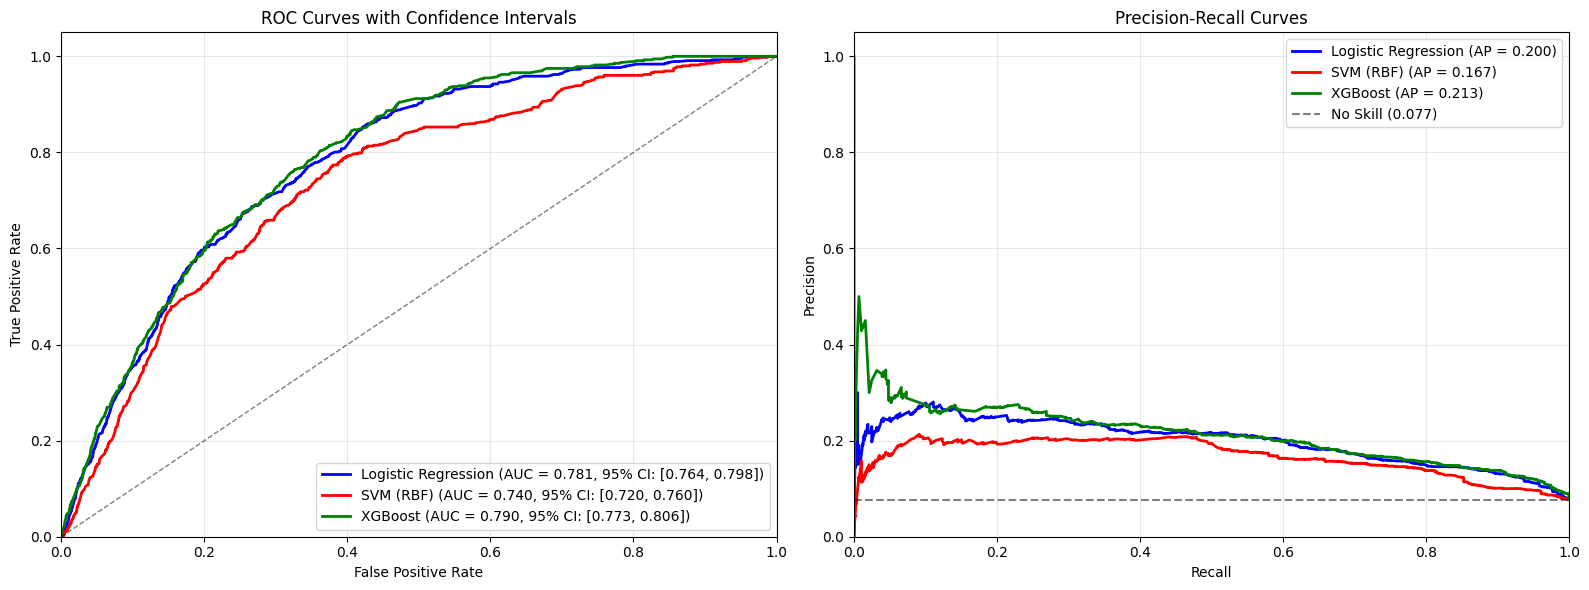

ROC Analysis Results:
- Logistic Regression: AUC-ROC = 0.781
- SVM (RBF): AUC-ROC = 0.740
- XGBoost: AUC-ROC = 0.790
Precision Recall Analysis Results:
- Logistic Regression: Average Precision = 0.200
- SVM (RBF): Average Precision = 0.167
- XGBoost: Average Precision = 0.213

Probability Calibration Analysis
- Logistic Regression: Brier Score = 0.1956 (lower is better)
- SVM (RBF): Brier Score = 0.0677 (lower is better)
- XGBoost: Brier Score = 0.1069 (lower is better)


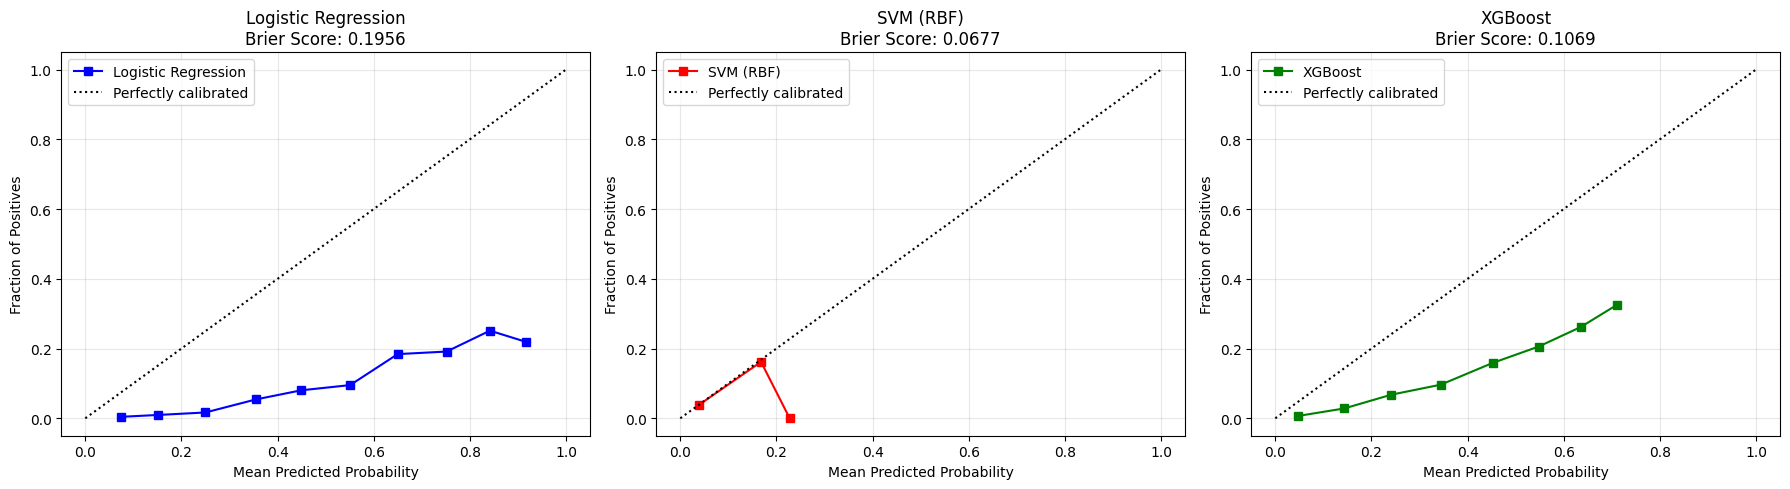

In [11]:
# Advanced Model Analysis

print("Advanced Model Analysis")

# ROC Curv Analysis
print("\nROC Curve Analysis")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
models_data = [
    ('Logistic Regression', lr_pred_proba, 'blue'),
    ('SVM (RBF)', svm_pred_proba, 'red'), 
    ('XGBoost', xgb_pred_proba, 'green')
]

for name, proba, color in models_data:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    
    # Bootstrap confidence intervals for AUC
    n_bootstraps = 1000
    bootstrap_aucs = []
    rng = np.random.RandomState(42)
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_test), len(y_test))
        if len(np.unique(y_test.iloc[indices])) < 2:
            continue
        bootstrap_auc = roc_auc_score(y_test.iloc[indices], proba[indices])
        bootstrap_aucs.append(bootstrap_auc)
    
    ci_lower = np.percentile(bootstrap_aucs, 2.5)
    ci_upper = np.percentile(bootstrap_aucs, 97.5)
    
    ax1.plot(fpr, tpr, color=color, lw=2, 
            label=f'{name} (AUC = {auc:.3f}, 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}])')

ax1.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves with Confidence Intervals')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision Recall Curves
print("\nPrecision Recall Curve Analysis")

for name, proba, color in models_data:
    precision, recall, thresholds = precision_recall_curve(y_test, proba)
    avg_precision = average_precision_score(y_test, proba)
    
    ax2.plot(recall, precision, color=color, lw=2,
            label=f'{name} (AP = {avg_precision:.3f})')

# No skill baseline (random classifier)
no_skill = len(y_test[y_test == 1]) / len(y_test)
ax2.axhline(y=no_skill, color='k', linestyle='--', alpha=0.5, 
           label=f'No Skill ({no_skill:.3f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/advanced_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC Analysis Results:")
for name, proba, _ in models_data:
    auc = roc_auc_score(y_test, proba)
    print(f"- {name}: AUC-ROC = {auc:.3f}")

print("Precision Recall Analysis Results:")
for name, proba, _ in models_data:
    avg_precision = average_precision_score(y_test, proba)
    print(f"- {name}: Average Precision = {avg_precision:.3f}")

# Probablility Calibration Analysis
print("\nProbability Calibration Analysis")

ig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, proba, color) in enumerate(models_data):
    # Calibration curve
    fraction_pos, mean_pred_value = calibration_curve(y_test, proba, n_bins=10)
    
    axes[idx].plot(mean_pred_value, fraction_pos, "s-", color=color, label=name)
    axes[idx].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    # Brier Score
    brier_score = brier_score_loss(y_test, proba)
    
    axes[idx].set_xlabel('Mean Predicted Probability')
    axes[idx].set_ylabel('Fraction of Positives')
    axes[idx].set_title(f'{name}\nBrier Score: {brier_score:.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    print(f"- {name}: Brier Score = {brier_score:.4f} (lower is better)")

plt.tight_layout()
plt.savefig('../results/figures/probability_calibration.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Threshold Optimization and Business Cost Analysis

Threshold Optimization and Business Cost Analysis

Cost Sensitive Evaluation
Business Cost Structure:
- Cost of False Positive (wasted due diligence): $50,000
- Cost of False Negative (missed opportunity): $500,000
- Expected ROI per True Positive: $1,000,000

Threshold Tuning Optimization


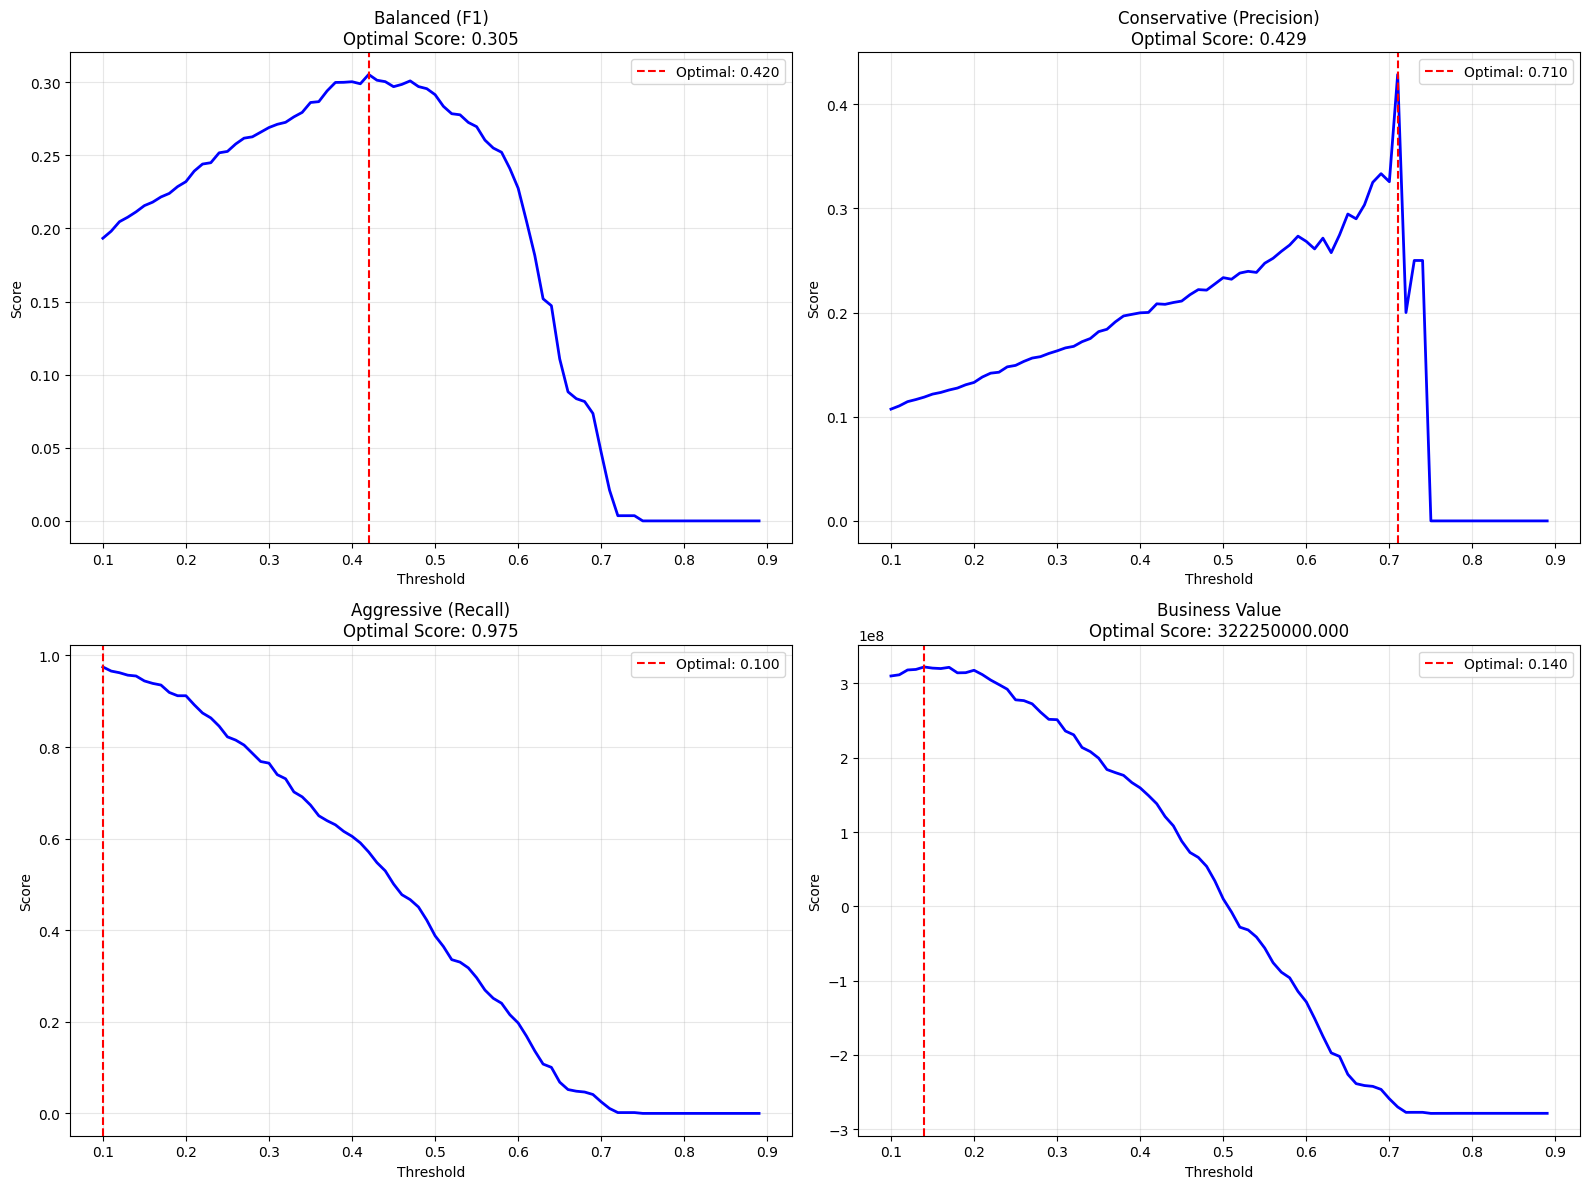

Optimal Threshold By Scenario:
- Balanced (F1): 0.420 (Score: 0.305)
- Conservative (Precision): 0.710 (Score: 0.429)
- Aggressive (Recall): 0.100 (Score: 0.975)
- Business Value: 0.140 (Score: 322250000.000)

Investment Simulation
Invesment Simulation Results:
----------------------------------------
Random Selection Baseline:
- Investments Made: 100
- Successful Investments: 8
- Success Rate: 8.0%
- ROI: -92.0%

XGBoost Model Guided Selection:
- Investments Made: 100
- Successful Investments: 29
- Success Rate: 29.0%
- ROI: -71.0%

Model Improvement: 21.0 percentage points ROI increase


In [12]:
# Threshold Optimization and Business Cost Analysis
print("Threshold Optimization and Business Cost Analysis")

# Cost Sensititve Evaluation
print("\nCost Sensitive Evaluation")

# Business costs (hypothetical but realistic)
COST_FALSE_POSITIVE = 50000  # Cost of wasted due diligence
COST_FALSE_NEGATIVE = 500000  # Cost of missed opportunity  
EXPECTED_ROI_TRUE_POSITIVE = 1000000  # Expected ROI per successful investment

print("Business Cost Structure:")
print(f"- Cost of False Positive (wasted due diligence): ${COST_FALSE_POSITIVE:,}")
print(f"- Cost of False Negative (missed opportunity): ${COST_FALSE_NEGATIVE:,}")
print(f"- Expected ROI per True Positive: ${EXPECTED_ROI_TRUE_POSITIVE:,}")

def calculate_business_value(y_true, y_pred, y_proba):
    """Calculates business value based on cost structure"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    total_cost = (fp * COST_FALSE_POSITIVE + 
                  fn * COST_FALSE_NEGATIVE)
    total_benefit = tp * EXPECTED_ROI_TRUE_POSITIVE
    net_value = total_benefit - total_cost
    
    return {
        'net_value': net_value,
        'total_benefit': total_benefit,
        'total_cost': total_cost,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

# Threshold Tuning Optimization
print("\nThreshold Tuning Optimization")

def optimize_threshold(y_true, y_proba, metric='f1'):
    """Finds optimal threshold for different business scenarios"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred_thresh)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred_thresh)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred_thresh)
        elif metric == 'business_value':
            business_metrics = calculate_business_value(y_true, y_pred_thresh, y_proba)
            score = business_metrics['net_value']
        
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    return thresholds[optimal_idx], scores[optimal_idx], thresholds, scores

# Threshold optimization for XGBoost (best preforming model)
scenarios = {
    'Balanced (F1)': 'f1',
    'Conservative (Precision)': 'precision', 
    'Aggressive (Recall)': 'recall',
    'Business Value': 'business_value'
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

threshold_results = {}

for idx, (scenario_name, metric) in enumerate(scenarios.items()):
    optimal_thresh, optimal_score, thresholds, scores = optimize_threshold(
        y_test, xgb_pred_proba, metric)
    
    threshold_results[scenario_name] = {
        'threshold': optimal_thresh,
        'score': optimal_score
    }
    
    axes[idx].plot(thresholds, scores, 'b-', linewidth=2)
    axes[idx].axvline(x=optimal_thresh, color='r', linestyle='--', 
                      label=f'Optimal: {optimal_thresh:.3f}')
    axes[idx].set_xlabel('Threshold')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(f'{scenario_name}\nOptimal Score: {optimal_score:.3f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Optimal Threshold By Scenario:")
for scenario, results in threshold_results.items():
    print(f"- {scenario}: {results['threshold']:.3f} (Score: {results['score']:.3f})")

# Investment Simulation
print("\nInvestment Simulation")

def simulate_vc_fund(y_true, y_proba, threshold=0.5, fund_size=100000000, 
                     investment_per_company=1000000):
    """Simulates VC fund performance using model predictions"""
    
    y_pred = (y_proba >= threshold).astype(int)
    max_investments = fund_size // investment_per_company
    
    # Get top predictions up to fund capacity
    top_indices = np.argsort(y_proba)[::-1][:max_investments]
    selected_predictions = y_pred[top_indices]
    selected_actual = y_true.iloc[top_indices]
    
    # Calculate returns
    investments_made = len(selected_predictions)
    successful_investments = np.sum(selected_actual)
    total_invested = investments_made * investment_per_company
    total_returns = successful_investments * EXPECTED_ROI_TRUE_POSITIVE
    net_profit = total_returns - total_invested
    roi_percentage = (net_profit / total_invested) * 100 if total_invested > 0 else 0
    
    return {
        'investments_made': investments_made,
        'successful_investments': successful_investments,
        'success_rate': successful_investments / investments_made if investments_made > 0 else 0,
        'total_invested': total_invested,
        'total_returns': total_returns,
        'net_profit': net_profit,
        'roi_percentage': roi_percentage
    }

# Random selection baseline
random_indices = np.random.choice(len(y_test), size=min(100, len(y_test)), replace=False)
random_baseline = simulate_vc_fund(y_test, np.random.random(len(y_test)))

# Model guided selection
model_results = simulate_vc_fund(y_test, xgb_pred_proba, threshold=0.3)

print("Invesment Simulation Results:")
print("-" * 40)
print("Random Selection Baseline:")
print(f"- Investments Made: {random_baseline['investments_made']}")
print(f"- Successful Investments: {random_baseline['successful_investments']}")
print(f"- Success Rate: {random_baseline['success_rate']:.1%}")
print(f"- ROI: {random_baseline['roi_percentage']:.1f}%")

print("\nXGBoost Model Guided Selection:")
print(f"- Investments Made: {model_results['investments_made']}")
print(f"- Successful Investments: {model_results['successful_investments']}")
print(f"- Success Rate: {model_results['success_rate']:.1%}")
print(f"- ROI: {model_results['roi_percentage']:.1f}%")

improvement = model_results['roi_percentage'] - random_baseline['roi_percentage']
print(f"\nModel Improvement: {improvement:.1f} percentage points ROI increase")


## 4. Feature Analysis Deeper Dive

Feature Analysis Deeper Dive

Feature Stability Analysis
Top 15 Most Stable Features (XGBoost):
 1. founded_year_std          Importance: 0.1559 ± 0.0134
 2. era_recovery              Importance: 0.1515 ± 0.0327
 3. era_dotcom_era            Importance: 0.0907 ± 0.0049
 4. era_post_crash            Importance: 0.0903 ± 0.0240
 5. is_usa                    Importance: 0.0604 ± 0.0044
 6. category_biotechnology    Importance: 0.0509 ± 0.0030
 7. category_health           Importance: 0.0401 ± 0.0042
 8. region_startup_density    Importance: 0.0388 ± 0.0034
 9. city_startup_density      Importance: 0.0363 ± 0.0042
10. category_web              Importance: 0.0349 ± 0.0034
11. category_advertising      Importance: 0.0303 ± 0.0049
12. category_technology       Importance: 0.0290 ± 0.0046
13. category_enterprise       Importance: 0.0241 ± 0.0025
14. category_mobile           Importance: 0.0232 ± 0.0029
15. category_curated          Importance: 0.0228 ± 0.0064


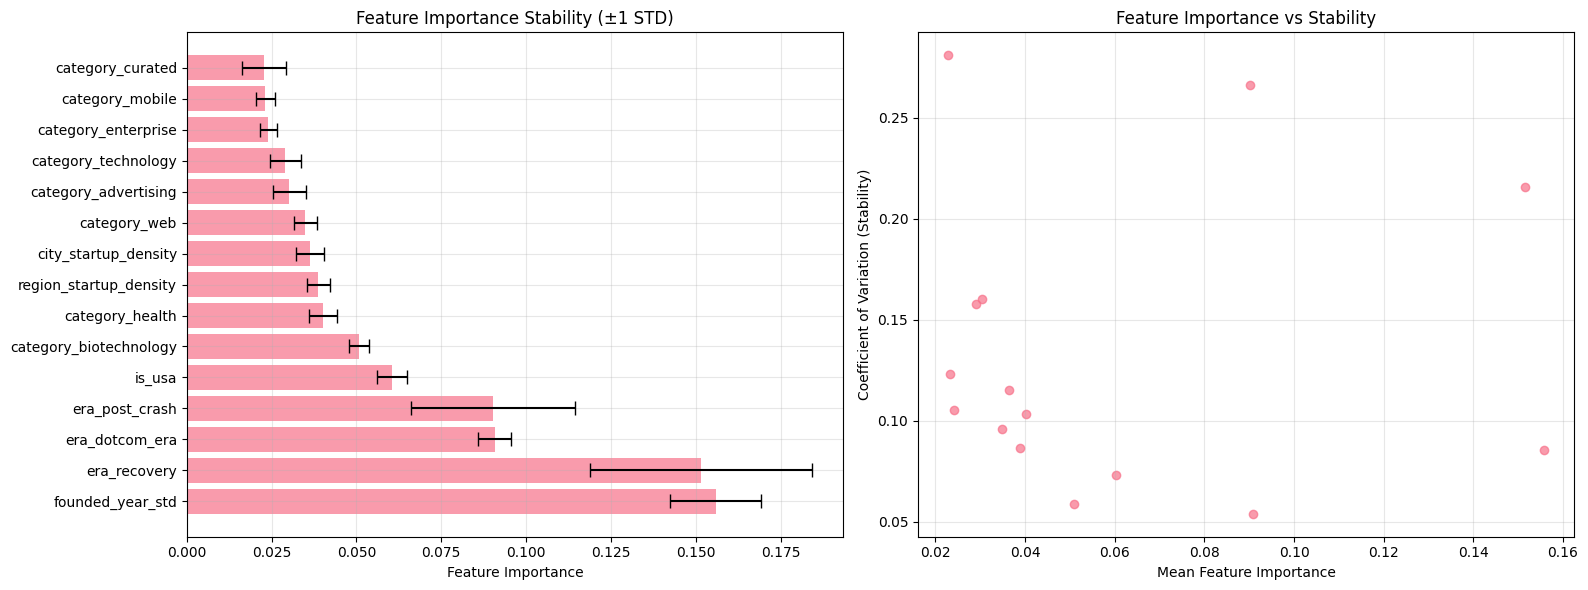


Geographic and Industry Feature Analysis
Geographic Feature Analysis:
Total Geographic Importance: 0.137 (13.7%)
- is_usa: 0.0701 (51.0% of geo)
- city_startup_density: 0.0355 (25.9% of geo)
- region_startup_density: 0.0317 (23.1% of geo)

Industry Feature Analysis:
Total Industry Importance: 0.374 (37.4%)
- Biotechnology: 0.0504 (13.5% of industry)
- Web: 0.0354 (9.5% of industry)
- Advertising: 0.0336 (9.0% of industry)
- Curated: 0.0336 (9.0% of industry)
- Health: 0.0331 (8.8% of industry)
- Enterprise: 0.0263 (7.0% of industry)
- Technology: 0.0258 (6.9% of industry)
- Mobile: 0.0224 (6.0% of industry)

Success Rate Analysis by Top Features:

is_usa:
  Success rate (feature=1): 9.7% (n=17697)
  Success rate (feature=0): 4.5% (n=11163)
  Lift: 2.15x

era_recovery:
  Success rate (feature=1): 3.5% (n=17488)
  Success rate (feature=0): 14.2% (n=11372)
  Lift: 0.25x

category_biotechnology:
  Success rate (feature=1): 5.1% (n=2011)
  Success rate (feature=0): 7.9% (n=26849)
  Lift: 0

In [14]:
# Feature Analysis Deeper Dive
print("Feature Analysis Deeper Dive")

# Loads training data for this analysis
X_train = pd.read_csv('../data/processed/X_train_stratified.csv')
y_train = pd.read_csv('../data/processed/y_train_stratified.csv').iloc[:, 0]

# Feature categories
geographic_features = ['region_startup_density', 'city_startup_density', 'is_usa']
industry_features = [col for col in X_train.columns if col.startswith('category_')]
temporal_features = ['founded_year_std', 'era_dotcom_era', 'era_post_crash', 'era_recovery']

# Feature Stability Analysis
print("\nFeature Stability Analysis")

def feature_stability_analysis(model, X, y, feature_names, cv_folds=5):
    """Analyzes feature importance consistency across CV folds"""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    feature_importances = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train = X.iloc[train_idx]
        y_fold_train = y.iloc[train_idx]
        
        # Trains model on fold
        model_fold = type(model)(**model.get_params())
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Gets feature importances
        if hasattr(model_fold, 'feature_importances_'):
            importances = model_fold.feature_importances_
        elif hasattr(model_fold, 'coef_'):
            importances = np.abs(model_fold.coef_[0])
        else:
            continue
            
        feature_importances.append(importances)
    
    # Calculates stability metrics
    feature_importances = np.array(feature_importances)
    mean_importance = np.mean(feature_importances, axis=0)
    std_importance = np.std(feature_importances, axis=0)
    cv_importance = std_importance / (mean_importance + 1e-8)  # Coefficient of variation
    
    stability_df = pd.DataFrame({
        'feature': feature_names,
        'mean_importance': mean_importance,
        'std_importance': std_importance,
        'cv_stability': cv_importance
    }).sort_values('mean_importance', ascending=False)
    
    return stability_df

# Analyzes XGBoost stability
xgb_stability = feature_stability_analysis(xgb_best, X_train, y_train, X_train.columns)

print("Top 15 Most Stable Features (XGBoost):")
stable_features = xgb_stability.head(15)
for i, (_, row) in enumerate(stable_features.iterrows(), 1):
    print(f"{i:2}. {row['feature']:<25} Importance: {row['mean_importance']:.4f} ± {row['std_importance']:.4f}")

# Visualizes stability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Feature importance w/ error bars
top_features = xgb_stability.head(15)
ax1.barh(range(len(top_features)), top_features['mean_importance'], 
         xerr=top_features['std_importance'], alpha=0.7, capsize=5)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Feature Importance Stability (±1 STD)')
ax1.grid(True, alpha=0.3)

# Coefficient of variation
ax2.scatter(top_features['mean_importance'], top_features['cv_stability'], alpha=0.7)
ax2.set_xlabel('Mean Feature Importance')
ax2.set_ylabel('Coefficient of Variation (Stability)')
ax2.set_title('Feature Importance vs Stability')
ax2.grid(True, alpha=0.3)

# Labels for most unstable features
for i, (_, row) in enumerate(top_features.iterrows()):
    if row['cv_stability'] > 0.5:  # Flag unstable features
        ax2.annotate(row['feature'], (row['mean_importance'], row['cv_stability']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.savefig('../results/figures/feature_stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Geographic and Industry Feature Analysis
print("\nGeographic and Industry Feature Analysis")

# Geographic analysis
print("Geographic Feature Analysis:")
geo_importance = feature_importance[feature_importance['feature'].isin(geographic_features)]
geo_total = geo_importance['importance'].sum()
print(f"Total Geographic Importance: {geo_total:.3f} ({geo_total*100:.1f}%)")

for _, row in geo_importance.iterrows():
    print(f"- {row['feature']}: {row['importance']:.4f} ({row['importance']/geo_total*100:.1f}% of geo)")

# Industry analysis
print("\nIndustry Feature Analysis:")
industry_importance = feature_importance[feature_importance['feature'].isin(industry_features)]
industry_total = industry_importance['importance'].sum()
print(f"Total Industry Importance: {industry_total:.3f} ({industry_total*100:.1f}%)")

top_industries = industry_importance.head(8)
for _, row in top_industries.iterrows():
    clean_name = row['feature'].replace('category_', '').title()
    print(f"- {clean_name}: {row['importance']:.4f} ({row['importance']/industry_total*100:.1f}% of industry)")

# Success rates by feature
def analyze_success_by_feature(X, y, feature_name):
    """Analyze success rates by feature values"""
    if feature_name.startswith('category_') or feature_name.startswith('era_') or feature_name in ['is_usa']:
        # Binary features
        feature_values = X[feature_name]
        success_rate_1 = y[feature_values == 1].mean() if (feature_values == 1).sum() > 0 else 0
        success_rate_0 = y[feature_values == 0].mean() if (feature_values == 0).sum() > 0 else 0
        
        return {
            'feature': feature_name,
            'success_rate_positive': success_rate_1,
            'success_rate_negative': success_rate_0,
            'lift': success_rate_1 / success_rate_0 if success_rate_0 > 0 else float('inf'),
            'count_positive': (feature_values == 1).sum(),
            'count_negative': (feature_values == 0).sum()
        }
    else:
        # Continuous features (analyzes by quartiles)
        quartiles = np.quantile(X[feature_name], [0.25, 0.5, 0.75])
        q1_mask = X[feature_name] <= quartiles[0]
        q4_mask = X[feature_name] >= quartiles[2]
        
        success_q1 = y[q1_mask].mean() if q1_mask.sum() > 0 else 0
        success_q4 = y[q4_mask].mean() if q4_mask.sum() > 0 else 0
        
        return {
            'feature': feature_name,
            'success_rate_q1': success_q1,
            'success_rate_q4': success_q4,
            'lift': success_q4 / success_q1 if success_q1 > 0 else float('inf'),
            'count_q1': q1_mask.sum(),
            'count_q4': q4_mask.sum()
        }

# Analyzes top features
print("\nSuccess Rate Analysis by Top Features:")
combined_data = pd.concat([X_train, y_train.rename('success')], axis=1)

for feature in ['is_usa', 'era_recovery', 'category_biotechnology', 'category_web']:
    analysis = analyze_success_by_feature(X_train, y_train, feature)
    if 'success_rate_positive' in analysis:
        print(f"\n{feature}:")
        print(f"  Success rate (feature=1): {analysis['success_rate_positive']:.1%} (n={analysis['count_positive']})")
        print(f"  Success rate (feature=0): {analysis['success_rate_negative']:.1%} (n={analysis['count_negative']})")
        print(f"  Lift: {analysis['lift']:.2f}x")


## Temporal Validation and Robustness

In [15]:
# Temporal Validation and Robustness
print("Temporal Validation and Robustness")

# Era Based Analysis
print("\nEra Based Analysis")

# Combines data for era analysis
full_data = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
full_target = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Defines eras based on features
eras = {
    'Dot com Era (1995-2000)': full_data['era_dotcom_era'] == 1,
    'Post crash (2001-2008)': full_data['era_post_crash'] == 1, 
    'Recovery (2009-2015)': full_data['era_recovery'] == 1
}

print("Success Rates by Era:")
era_analysis = {}
for era_name, era_mask in eras.items():
    if era_mask.sum() > 0:
        era_success_rate = full_target[era_mask].mean()
        era_count = era_mask.sum()
        era_analysis[era_name] = {
            'success_rate': era_success_rate,
            'count': era_count
        }
        print(f"- {era_name}: {era_success_rate:.1%} success rate (n={era_count:,})")

# Walk Forward Validation
print("\nWalk Forward Validation")

# Simulates the walk forward validation using founded_year_std as proxy for temporal order
def walk_forward_validation(X, y, model, n_splits=3):
    """Performs walk forward validation"""
    
    # Sorts by founded year (standardized)
    temporal_order = np.argsort(X['founded_year_std'])
    X_sorted = X.iloc[temporal_order]
    y_sorted = y.iloc[temporal_order]
    
    split_size = len(X_sorted) // (n_splits + 1)
    results = []
    
    for i in range(n_splits):
        train_end = split_size * (i + 2)
        test_start = split_size * (i + 2)
        test_end = split_size * (i + 3) if i < n_splits - 1 else len(X_sorted)
        
        if test_start >= len(X_sorted):
            break
            
        X_train_fold = X_sorted.iloc[:train_end]
        y_train_fold = y_sorted.iloc[:train_end] 
        X_test_fold = X_sorted.iloc[test_start:test_end]
        y_test_fold = y_sorted.iloc[test_start:test_end]
        
        if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_test_fold)) < 2:
            continue
            
        # Trains and evaluates
        model_fold = type(model)(**model.get_params())
        model_fold.fit(X_train_fold, y_train_fold)
        
        y_pred_fold = model_fold.predict(X_test_fold)
        y_proba_fold = model_fold.predict_proba(X_test_fold)[:, 1]
        
        fold_results = {
            'fold': i + 1,
            'train_size': len(X_train_fold),
            'test_size': len(X_test_fold),
            'precision': precision_score(y_test_fold, y_pred_fold),
            'recall': recall_score(y_test_fold, y_pred_fold),
            'f1': f1_score(y_test_fold, y_pred_fold),
            'auc': roc_auc_score(y_test_fold, y_proba_fold)
        }
        results.append(fold_results)
        
        print(f"Fold {i+1}: F1={fold_results['f1']:.3f}, Precision={fold_results['precision']:.3f}, "
              f"Recall={fold_results['recall']:.3f}, AUC={fold_results['auc']:.3f}")
    
    return pd.DataFrame(results)

# Performs walk forward validation
print("Walk Forward Validation Results:")
wf_results = walk_forward_validation(X_train, y_train, xgb_best, n_splits=3)

if len(wf_results) > 0:
    print("\nTemporal Performance Stability:")
    print(f"- Mean F1-Score: {wf_results['f1'].mean():.3f} ± {wf_results['f1'].std():.3f}")
    print(f"- Mean Precision: {wf_results['precision'].mean():.3f} ± {wf_results['precision'].std():.3f}")
    print(f"- Mean Recall: {wf_results['recall'].mean():.3f} ± {wf_results['recall'].std():.3f}")
    print(f"- Performance Trend: {'Improving' if wf_results['f1'].iloc[-1] > wf_results['f1'].iloc[0] else 'Declining'}")

# Class Balance Evolution
print("\nClass Balance Evolution")

# Analyzes class balance by era
print("Class Balance by Era:")
for era_name, era_mask in eras.items():
    if era_mask.sum() > 0:
        positive_class = full_target[era_mask].sum()
        total_class = era_mask.sum()
        balance_ratio = positive_class / total_class
        print(f"- {era_name}: {positive_class:,}/{total_class:,} = {balance_ratio:.1%}")


Temporal Validation and Robustness

Era Based Analysis
Success Rates by Era:
- Dot com Era (1995-2000): 20.2% success rate (n=2,908)
- Post crash (2001-2008): 12.7% success rate (n=11,336)
- Recovery (2009-2015): 3.5% success rate (n=21,831)

Walk Forward Validation
Walk Forward Validation Results:
Fold 1: F1=0.018, Precision=0.100, Recall=0.010, AUC=0.696
Fold 2: F1=0.000, Precision=0.000, Recall=0.000, AUC=0.706

Temporal Performance Stability:
- Mean F1-Score: 0.009 ± 0.013
- Mean Precision: 0.050 ± 0.071
- Mean Recall: 0.005 ± 0.007
- Performance Trend: Declining

Class Balance Evolution
Class Balance by Era:
- Dot com Era (1995-2000): 586/2,908 = 20.2%
- Post crash (2001-2008): 1,444/11,336 = 12.7%
- Recovery (2009-2015): 755/21,831 = 3.5%


## 6. Error Analysis and Model Limitations

In [16]:
# Error Analysis and Model Limitations
print("Error Analysis and Model Limitations")

# Misclassification Analysis
print("\nMissclassification Analysis")

# Analyzes false positives and false negatives for XGBoost
xgb_pred_test = xgb_best.predict(X_test)
xgb_proba_test = xgb_best.predict_proba(X_test)[:, 1]

# Identifies misclassifications
false_positives = (xgb_pred_test == 1) & (y_test == 0)
false_negatives = (xgb_pred_test == 0) & (y_test == 1)
true_positives = (xgb_pred_test == 1) & (y_test == 1)
true_negatives = (xgb_pred_test == 0) & (y_test == 0)

print(f"Misclassification Summary:")
print(f"- False Positives: {false_positives.sum():,} ({false_positives.mean():.1%})")
print(f"- False Negatives: {false_negatives.sum():,} ({false_negatives.mean():.1%})")
print(f"- True Positives: {true_positives.sum():,}")
print(f"- True Negatives: {true_negatives.sum():,}")

def analyze_misclassification_patterns(X, y, predictions, probabilities, feature_importance_df):
    """Analyzes patterns in misclassified examples"""
    
    false_positives = (predictions == 1) & (y == 0)
    false_negatives = (predictions == 0) & (y == 1)
    
    # Gets top important features
    top_features = feature_importance_df.head(10)['feature'].tolist()
    
    # Analyzes false positives
    fp_analysis = {}
    if false_positives.sum() > 0:
        fp_data = X[false_positives]
        fp_analysis = {
            'count': false_positives.sum(),
            'avg_probability': probabilities[false_positives].mean(),
            'feature_means': fp_data[top_features].mean()
        }
    
    # Analyzes false negatives  
    fn_analysis = {}
    if false_negatives.sum() > 0:
        fn_data = X[false_negatives]
        fn_analysis = {
            'count': false_negatives.sum(),
            'avg_probability': probabilities[false_negatives].mean(),
            'feature_means': fn_data[top_features].mean()
        }
    
    return fp_analysis, fn_analysis

fp_analysis, fn_analysis = analyze_misclassification_patterns(
    X_test, y_test, xgb_pred_test, xgb_proba_test, feature_importance)

print("\nFalse Positive Analysis:")
if fp_analysis:
    print(f"- Count: {fp_analysis['count']:,}")
    print(f"- Average predicted probability: {fp_analysis['avg_probability']:.3f}")
    print("- Top feature characteristics:")
    for feature in feature_importance.head(5)['feature']:
        if feature in fp_analysis['feature_means']:
            value = fp_analysis['feature_means'][feature]
            overall_mean = X_test[feature].mean()
            print(f"  * {feature}: {value:.3f} (overall: {overall_mean:.3f})")

print("\nFalse Negative Analysis:")
if fn_analysis:
    print(f"- Count: {fn_analysis['count']:,}")
    print(f"- Average predicted probability: {fn_analysis['avg_probability']:.3f}")
    print("- Top feature characteristics:")
    for feature in feature_importance.head(5)['feature']:
        if feature in fn_analysis['feature_means']:
            value = fn_analysis['feature_means'][feature]
            overall_mean = X_test[feature].mean()
            print(f"  * {feature}: {value:.3f} (overall: {overall_mean:.3f})")

# Edge Case Detection
print("\nEdge Case Detection")

# High confidence wrong predictions
high_conf_wrong = ((xgb_proba_test > 0.8) & (y_test == 0)) | ((xgb_proba_test < 0.2) & (y_test == 1))
low_conf_correct = ((xgb_proba_test < 0.6) & (xgb_proba_test > 0.4) & (xgb_pred_test == y_test))

print(f"Edge Cases Identified:")
print(f"- High confidence wrong predictions: {high_conf_wrong.sum()}")
print(f"- Low confidence correct predictions: {low_conf_correct.sum()}")

# Model Reliability Assessment
print("\nModel Reliability Assessment")

# Prediction confidence analysis
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2

reliability_analysis = []
for i in range(len(confidence_bins) - 1):
    bin_mask = (xgb_proba_test >= confidence_bins[i]) & (xgb_proba_test < confidence_bins[i+1])
    if bin_mask.sum() > 0:
        bin_accuracy = (xgb_pred_test[bin_mask] == y_test[bin_mask]).mean()
        bin_count = bin_mask.sum()
        avg_confidence = xgb_proba_test[bin_mask].mean()
        
        reliability_analysis.append({
            'bin_center': bin_centers[i],
            'accuracy': bin_accuracy,
            'count': bin_count,
            'avg_confidence': avg_confidence
        })

reliability_df = pd.DataFrame(reliability_analysis)

print("Prediciton Confidence Analysis:")
for _, row in reliability_df.iterrows():
    print(f"- Confidence {row['bin_center']:.1f}: {row['accuracy']:.1%} accuracy (n={row['count']})")




Error Analysis and Model Limitations

Missclassification Analysis
Misclassification Summary:
- False Positives: 709 (9.8%)
- False Negatives: 341 (4.7%)
- True Positives: 216
- True Negatives: 5,949

False Positive Analysis:
- Count: 709
- Average predicted probability: 0.588
- Top feature characteristics:
  * era_recovery: 0.020 (overall: 0.602)
  * founded_year_std: -1.495 (overall: 0.002)
  * era_post_crash: 0.577 (overall: 0.314)
  * is_usa: 0.897 (overall: 0.611)
  * era_dotcom_era: 0.403 (overall: 0.084)

False Negative Analysis:
- Count: 341
- Average predicted probability: 0.328
- Top feature characteristics:
  * era_recovery: 0.390 (overall: 0.602)
  * founded_year_std: -0.345 (overall: 0.002)
  * era_post_crash: 0.522 (overall: 0.314)
  * is_usa: 0.645 (overall: 0.611)
  * era_dotcom_era: 0.088 (overall: 0.084)

Edge Case Detection
Edge Cases Identified:
- High confidence wrong predictions: 49
- Low confidence correct predictions: 747

Model Reliability Assessment
Prediciton 